# **Z 可视化**

In [2]:
import os
import sys
import numpy as np
import torch
import time
from pathlib import Path
from torch import nn
import torch.nn.functional as F
import math

sys.path.append(os.path.abspath("/home/jiajun_hu/Documents/fb_hw/scripts/reinforcement_learning/fb/url_benchmark"))
sys.path.append(os.path.abspath("/home/jiajun_hu/Documents/fb_hw/scripts/reinforcement_learning/fb"))
import TOOLBOX

In [3]:
##### 数据加载 ######
net_path = Path("/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/08-22_21-57_Pretrain_4096_randomization/models/latest.pt")
data_path = Path("/home/jiajun_hu/Documents/fb_hw/exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/08-22_21-57_Pretrain_4096_randomization/08-26_21-12-07_collect_50000_contact")

net_path = Path("exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-04_16-12_Pretrain_2048_meta_fb_loss/models/snapshot_step140000.pt")
data_path = Path("exp_local/fb_ddpg/Isaac-Velocity-Flat-Unitree-Go2-Direct-Norm-v0/09-04_16-12_Pretrain_2048_meta_fb_loss/09-09_15-37-23_collect_contact")


# 神经网络
device = 'cuda'
data_net = torch.load(net_path, weights_only=False)
backward_net = data_net['agent'].backward_net.to(device)

print("keys in data_net:", data_net.keys(),'\r\n')
print("keys in agent:", data_net['agent'].backward_net,'\r\n')

# 推理数据
data = np.load(data_path / "data.npz")

for key in data.files:
    print(f"{key}: {data[key].shape}")

keys in data_net: dict_keys(['agent', 'global_step', 'replay_loader', 'obs_normalizer']) 

keys in agent: BackwardMap(
  (B): Sequential(
    (0): Linear(in_features=9, out_features=526, bias=True)
    (1): LayerNorm((526,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Linear(in_features=526, out_features=526, bias=True)
    (4): ReLU()
    (5): Linear(in_features=526, out_features=50, bias=True)
  )
) 

actions: (250, 400, 12)
obs: (250, 400, 45)
goals: (250, 400, 9)
rewards: (250, 400)
obs_raw: (250, 400, 45)
goals_raw: (250, 400, 9)
goals_next: (250, 400, 9)


In [4]:
@torch.no_grad()
def reward_fn(obs, command):

    # Goal Index
    lin_vel_idx = [0, 1, 2]
    ang_vel_idx = [3, 4, 5]
    gravity_idx = [6, 7, 8]

    # compute reward
    num_epi  = obs.shape[0]
    num_envs = obs.shape[1]
    command  = command.expand(num_epi, num_envs, len(command))
    
    lin_vel_goal = obs[:, :, lin_vel_idx]
    ang_vel_goal = obs[:, :, ang_vel_idx]
    gravity_goal = obs[:, :, gravity_idx]

    # Linear Velocity Tracking
    lin_vel_xy_error = torch.norm(command[:, :, :2] - lin_vel_goal[:, :, :2], dim=2)
    lin_vel_xy_rew = torch.exp(-torch.square(lin_vel_xy_error / 0.3))   # 0.3

    # Yaw Angular Velocity Tracking
    ang_vel_z_error = torch.abs(command[:, :, 2] - ang_vel_goal[:, :, 2])
    ang_vel_z_rew = torch.exp(-torch.square(ang_vel_z_error / 0.2))     # 0.2

    # Gravity Direction Tracking
    target_gravity_b = torch.tensor([+0.0,   # X   /\      #0000ff
                                     +0.0,   # Y <-        #0000ff
                                     -1.0],  # Z           #0000ff
                                     device=obs.device)
    target_gravity_b = target_gravity_b / torch.norm(target_gravity_b)
    target_gravity_b = target_gravity_b.expand(num_epi, num_envs, len(target_gravity_b)).to(obs.device)

    ang_xy_error = torch.norm(gravity_goal - target_gravity_b, dim=2)
    ang_xy_rew = torch.exp(-torch.square(ang_xy_error / 0.1))

    task_rewards = {
        "lin_vel_xy_rew": lin_vel_xy_rew,
        "ang_vel_z_rew": ang_vel_z_rew,
        "ang_xy_rew": ang_xy_rew,
    }

    ######## 仅使用任务奖励 ########
    task_rewards = torch.prod(torch.stack(list(task_rewards.values())),dim=0)
    return task_rewards

## **计算 rewards + 推理 Z_rewards**

In [5]:
with torch.no_grad():

    obs_raw   = torch.tensor(data['obs_raw'], device=device)      #ff0000
    goal_next = torch.tensor(data['goals_next'], device=device)   #ff0000
    Zs = backward_net(goal_next).reshape(-1,50)

    rewards_list = []
    Z_reward_list = []
    command_list = torch.tensor([[+0.5,0.0,0.0],
                                 [-0.5,0.0,0.0],
                                 [+1.0,0.0,0.0],
                                 [-1.0,0.0,0.0],
                                 [0.0,+1.0,0.0],
                                 [0.0,-1.0,0.0],
                                 [0.0,0.0,+1.0],
                                 [0.0,0.0,-1.0],
                                ],device = device)

    for command in command_list:

        rewards = reward_fn(obs_raw, command).reshape(-1,1)
        Z_reward = torch.matmul(rewards.T, Zs) / rewards.shape[0]
        Z_reward = math.sqrt(50) * F.normalize(Z_reward, dim=1)

        rewards_list.append(rewards.cpu().numpy())
        Z_reward_list.append(Z_reward.cpu().numpy())

    # 转换为正确的numpy数组格式
    rewards_list  = np.array(rewards_list)   # 形状: (8, 50000, 1)
    Z_reward_list = np.array(Z_reward_list)  # 形状: (8, 1, 50)

print(f"command   shape: {command.shape}")
print(f"goal_next shape: {goal_next.shape}")
print(f"Z         shape: {Zs.shape}")
print(f"rewards   shape: {rewards.shape}")
print(f"Z_reward  shape: {Z_reward.shape}")

print(f"rewards_list shape: {rewards_list.shape}")
print(f"Z_reward_list shape: {Z_reward_list.shape}")

####################### 数据保存 ##########################
path = "UMAP.npz"
np.savez(path, 
         Zs=Zs.cpu().numpy(), 
         obs_raw=obs_raw.cpu().numpy(),
         rewards_list=rewards_list, 
         Z_reward_list=Z_reward_list)
print(path)


command   shape: torch.Size([3])
goal_next shape: torch.Size([250, 400, 9])
Z         shape: torch.Size([100000, 50])
rewards   shape: torch.Size([100000, 1])
Z_reward  shape: torch.Size([1, 50])
rewards_list shape: (8, 100000, 1)
Z_reward_list shape: (8, 1, 50)
UMAP.npz


## **UMAP**

In [6]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

######## 创建UMAP降维器 ########
reducer = umap.UMAP()

######## 加载数据 ########
data = np.load("UMAP.npz")

####### 查看数据内容 ######
print(data.keys())
print(data["Zs"].shape)
print(data["rewards_list"].shape)
print(data["Z_reward_list"].shape)

KeysView(NpzFile 'UMAP.npz' with keys: Zs, obs_raw, rewards_list, Z_reward_list)
(100000, 50)
(8, 100000, 1)
(8, 1, 50)


In [7]:
# 数据处理
Zs_UMAP = data["Zs"]
Zs_UMAP = np.vstack([Zs_UMAP, data["Z_reward_list"][0]])
print(Zs_UMAP.shape)

scaled_Zs_UMAP = StandardScaler().fit_transform(Zs_UMAP)

(100001, 50)


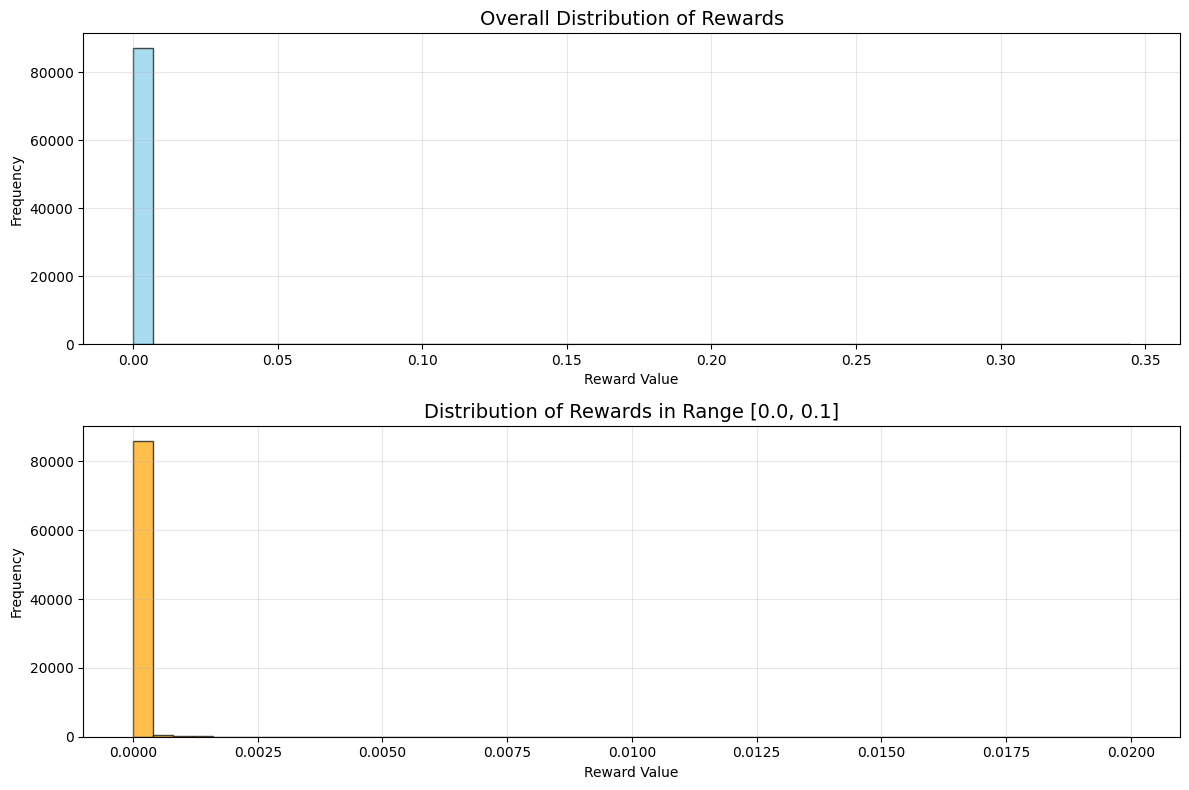

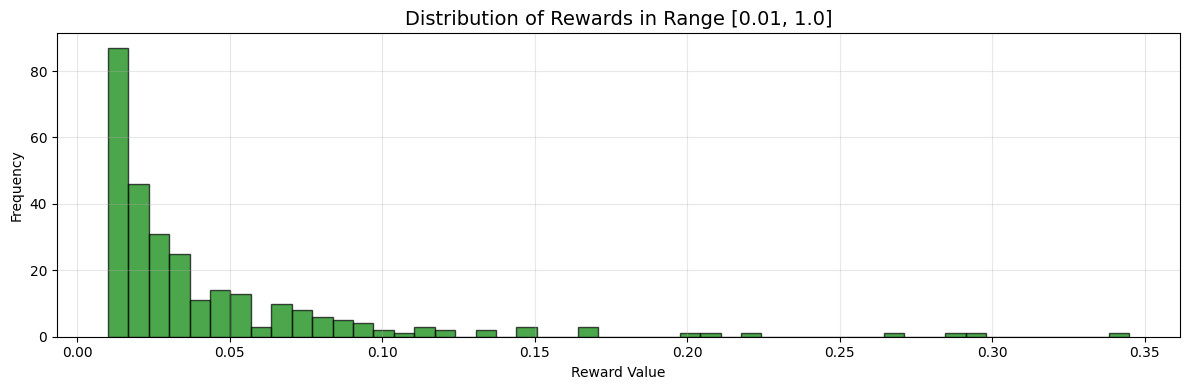

Total rewards: 87480
Rewards in [0.0, 0.1]: 286
Percentage in [0.0, 0.1]: 0.33%
max reward: 0.34481048583984375


In [23]:
#### 数据选择 ####
rewards_flat = data["rewards_list"][4].flatten()
mask_no_zero = rewards_flat != 0.0
rewards_flat = rewards_flat[mask_no_zero]

plt.figure(figsize=(12, 8))

# Subplot 1: Overall distribution
plt.subplot(2, 1, 1)
plt.hist(rewards_flat, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Overall Distribution of Rewards', fontsize=14)
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Subplot 2: Zoom in on 0.0-0.1 range
plt.subplot(2, 1, 2)
# Filter rewards in the 0.0-0.1 range
rewards_filtered = rewards_flat[(rewards_flat >= 0.0) & (rewards_flat <= 0.02)]
plt.hist(rewards_filtered, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Rewards in Range [0.0, 0.1]', fontsize=14)
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Subplot 3: Zoom in 0.1 - 1
rewards_filtered = rewards_flat[(rewards_flat >= 0.01) & (rewards_flat <= 1.0)]
plt.figure(figsize=(12, 4))
plt.hist(rewards_filtered, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Rewards in Range [0.01, 1.0]', fontsize=14)
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total rewards: {len(rewards_flat)}")
print(f"Rewards in [0.0, 0.1]: {len(rewards_filtered)}")
print(f"Percentage in [0.0, 0.1]: {len(rewards_filtered)/len(rewards_flat)*100:.2f}%")
print(f"max reward: {np.max(rewards_flat)}")


In [9]:
# 为每个command创建单独的可视化图
import matplotlib.pyplot as plt
import numpy as np

# Command的标签和对应的颜色
command_labels = [
    "Forward (+0.5, 0.0, 0.0)",
    "Backward (-0.5, 0.0, 0.0)",
    "Fast Forward (+1.0, 0.0, 0.0)",
    "Fast Backward (-1.0, 0.0, 0.0)",
    "Left (+0.0, +1.0, 0.0)",
    "Right (+0.0, -1.0, 0.0)",
    "Left Turn (0.0, 0.0, +1.0)",
    "Right Turn (0.0, 0.0, -1.0)"
]

# 读取保存的数据
data = np.load("UMAP.npz")
rewards_list = data["rewards_list"]  # (8, 50000, 1)
Z_reward_list = data["Z_reward_list"]  # (8, 1, 50)

# 需要重新计算UMAP embedding，因为我们需要为所有数据点计算坐标
# 将所有Zs合并，包括8个目标Z_reward点
goals = data["obs_raw"][:,:,0:9].reshape(-1,9)
Zs = data["Zs"]  # (50000, 50)
all_Z_rewards = Z_reward_list.reshape(-1, 50)  # (8, 50)
combined_Zs = np.vstack([Zs, all_Z_rewards])  # (50008, 50)

# 标准化
scaled_combined_obs = StandardScaler().fit_transform(goals)
scaled_combined_Zs  = StandardScaler().fit_transform(combined_Zs)

In [10]:
# 计算 obs_raw 的 UMAP 坐标
reducer_obs = umap.UMAP(random_state=42)
embedding_obs = reducer_obs.fit_transform(scaled_combined_obs)

# 计算 Zs UMAP 坐标
reducer_multi = umap.UMAP(random_state=42)
embedding_zs = reducer_multi.fit_transform(scaled_combined_Zs)

# 分离原始Zs的embedding和目标点的embedding
Zs_embedding      = embedding_zs[:-8]  # 原始Zs的坐标
targets_embedding = embedding_zs[-8:]  # 8个目标点的坐标

/home/jiajun_hu/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jiajun_hu/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/jiajun_hu/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


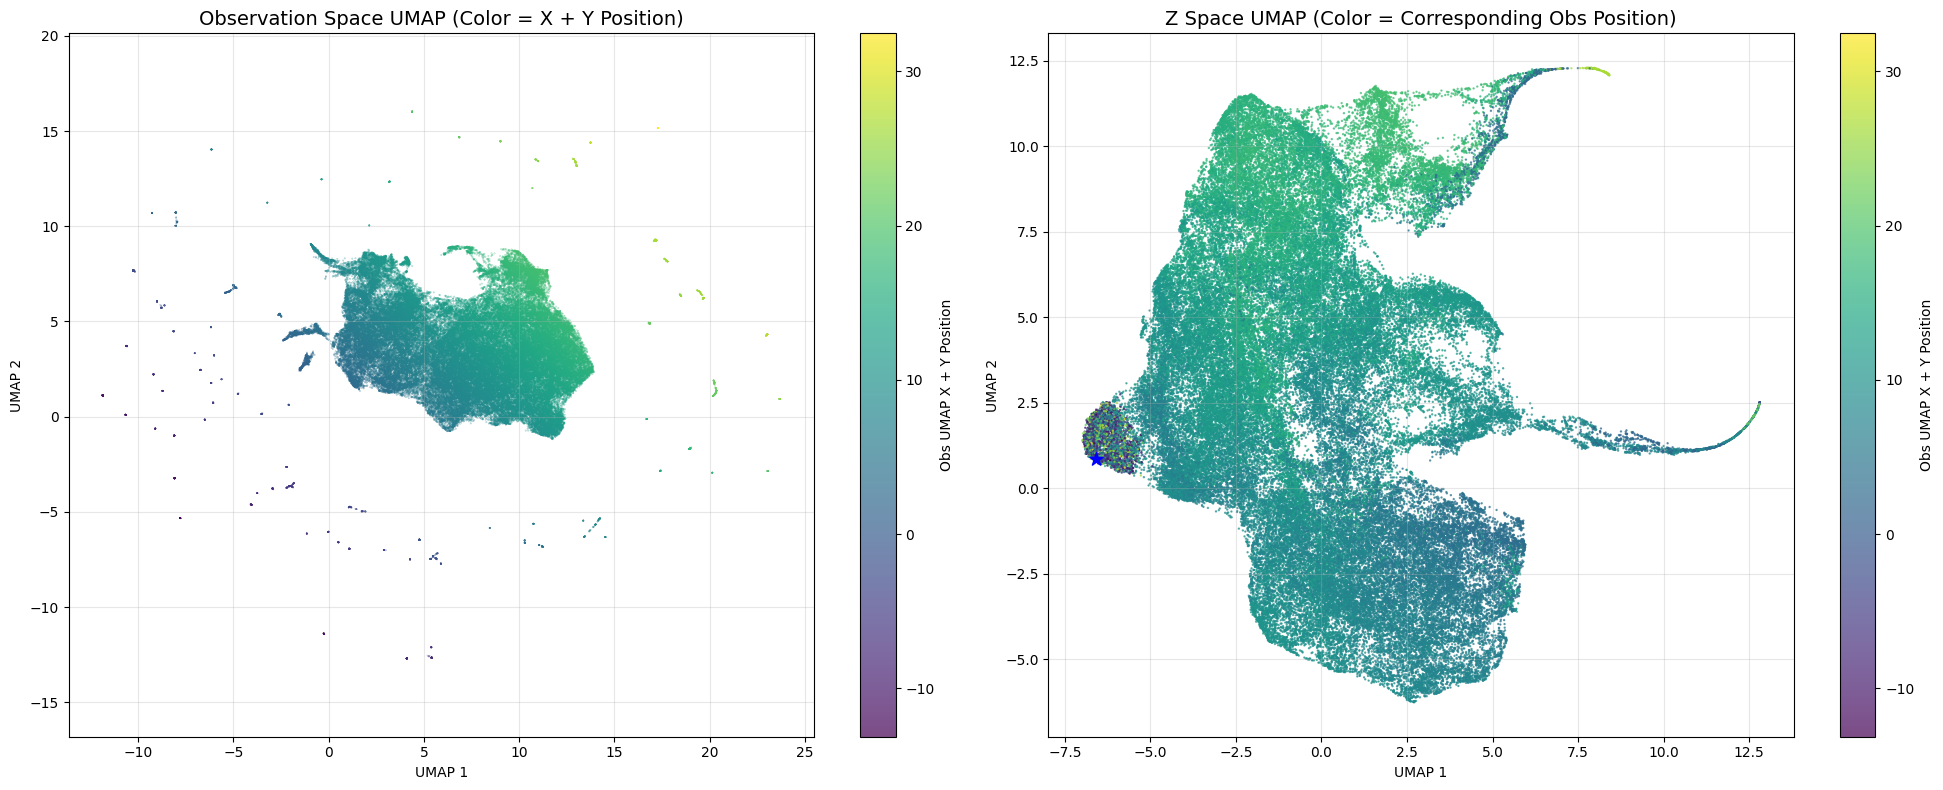

In [11]:
command_id = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Create color based on UMAP coordinates (X + Y position) for obs
obs_colors = embedding_obs[:, 0] + embedding_obs[:, 1]  # X + Y coordinates

# Use the same color mapping for Zs (based on obs colors, not Zs coordinates)
# This maintains the correspondence between obs and Zs
zs_colors = obs_colors  # Use obs colors for Zs to show mapping correspondence

# Plot obs with color gradient based on XY position
scatter1 = ax1.scatter(embedding_obs[:, 0], embedding_obs[:, 1], 
                      c=obs_colors, s=0.05, alpha=0.7, cmap='viridis')
ax1.set_title('Observation Space UMAP (Color = X + Y Position)', fontsize=14)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.axis("equal")
ax1.grid(True, alpha=0.3)

# Add colorbar for obs plot
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Obs UMAP X + Y Position', fontsize=10)

# Plot Zs with the same colors as obs to show correspondence
scatter2 = ax2.scatter(Zs_embedding[:, 0], Zs_embedding[:, 1], 
                      c=zs_colors, s=0.5, alpha=0.7, cmap='viridis')
ax2.scatter(targets_embedding[command_id, 0], 
            targets_embedding[command_id, 1], 
            c='blue', s=100, marker='*', label='Target Z Rewards')
ax2.set_title('Z Space UMAP (Color = Corresponding Obs Position)', fontsize=14)
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.axis("equal")
ax2.grid(True, alpha=0.3)

# Add colorbar for Zs plot
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Obs UMAP X + Y Position', fontsize=10)

plt.tight_layout()
plt.show()


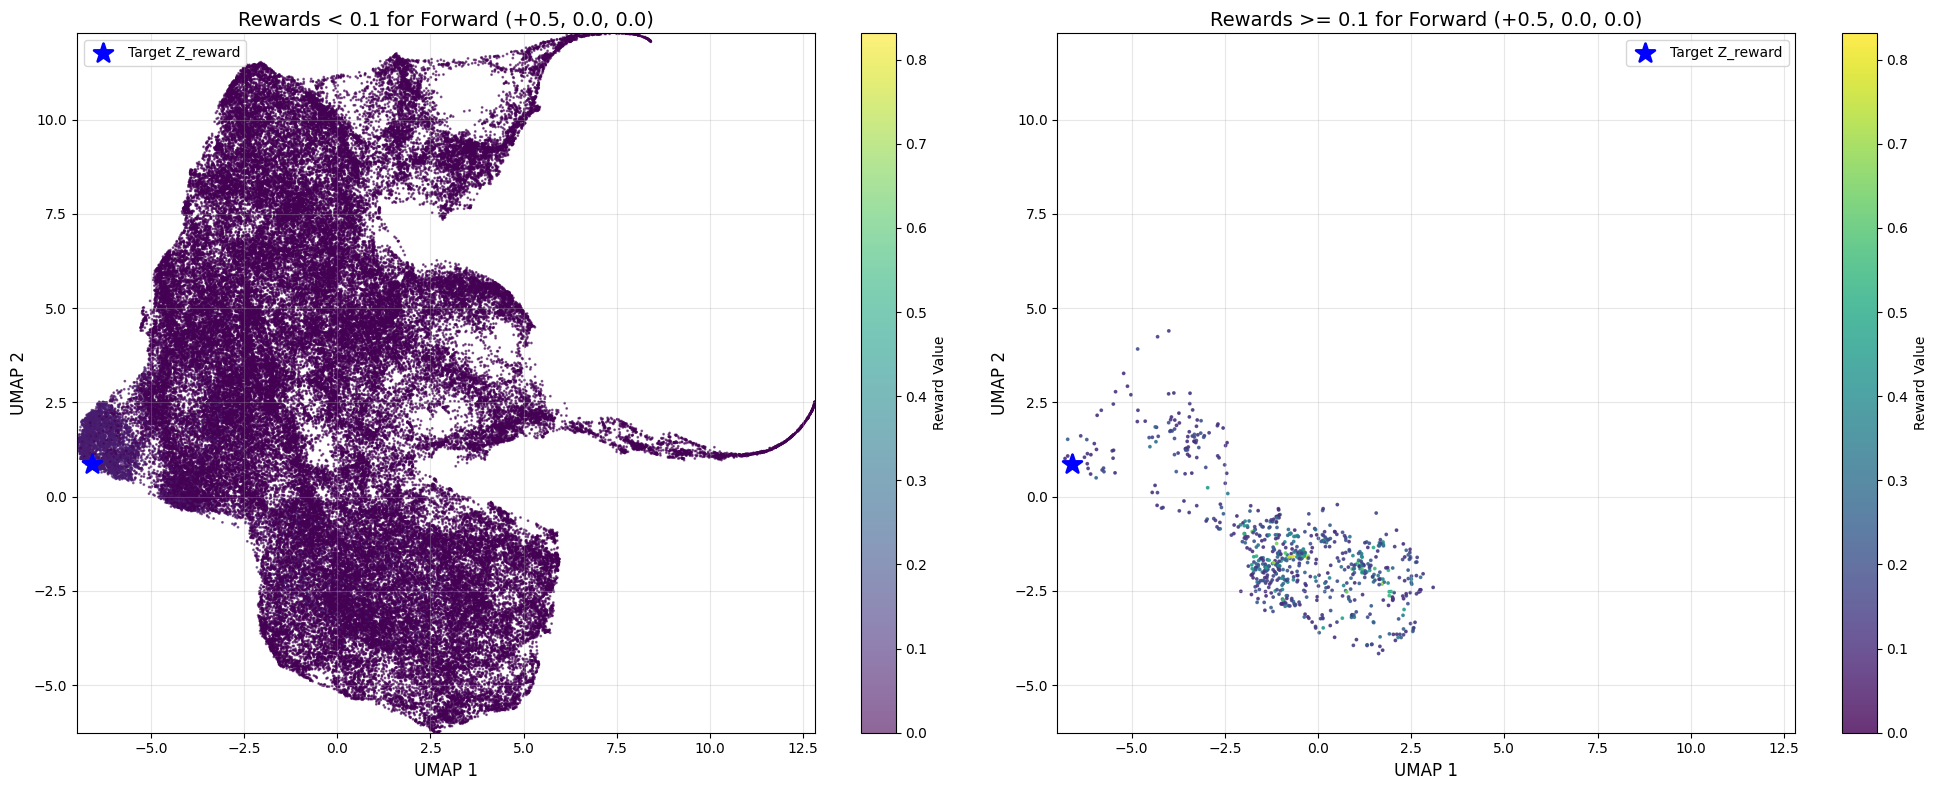

Command: Forward (+0.5, 0.0, 0.0)
Total points: 100000
Points with rewards < 0.1: 99317 (99.32%)
Points with rewards >= 0.1: 683 (0.68%)
Reward range: 0.000000 - 0.831246


In [12]:
# 选择要查看的command索引 (0-7)
command_to_view = 0  # 可以修改这个值来查看不同的command

# 获取当前command的rewards
current_rewards = rewards_list[command_to_view].flatten()

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 设置统一的颜色范围和坐标轴范围
vmin, vmax = 0, np.max(current_rewards)
x_min, x_max = np.min(Zs_embedding[:, 0]), np.max(Zs_embedding[:, 0])
y_min, y_max = np.min(Zs_embedding[:, 1]), np.max(Zs_embedding[:, 1])

# 第一个子图：rewards < 0.1
low_reward_mask = current_rewards < 0.1
scatter1 = ax1.scatter(
    Zs_embedding[low_reward_mask, 0], 
    Zs_embedding[low_reward_mask, 1],
    c=current_rewards[low_reward_mask],
    cmap='viridis',
    s=1.0,
    alpha=0.6,
    rasterized=True,
    vmin=vmin,
    vmax=vmax
)

# 添加目标点
ax1.scatter(
    targets_embedding[command_to_view, 0],
    targets_embedding[command_to_view, 1], 
    c='blue',
    s=200,
    marker='*',
    # edgecolors='white',
    linewidth=2,
    label='Target Z_reward',
    zorder=10
)

ax1.set_title(f'Rewards < 0.1 for {command_labels[command_to_view]}', fontsize=14)
ax1.set_xlabel('UMAP 1', fontsize=12)
ax1.set_ylabel('UMAP 2', fontsize=12)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# 添加颜色条
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Reward Value', fontsize=10)

# 第二个子图：rewards >= 0.1
high_reward_mask = current_rewards >= 0.1
if np.any(high_reward_mask):
    scatter2 = ax2.scatter(
        Zs_embedding[high_reward_mask, 0], 
        Zs_embedding[high_reward_mask, 1],
        c=current_rewards[high_reward_mask],
        cmap='viridis',
        s=3.0,
        alpha=0.8,
        rasterized=True,
        vmin=vmin,
        vmax=vmax
    )
    
    # 添加颜色条
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Reward Value', fontsize=10)
else:
    # 如果没有高奖励点，显示空图
    ax2.text(0.5, 0.5, 'No rewards >= 0.1', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=16)

# 添加目标点
ax2.scatter(
    targets_embedding[command_to_view, 0],
    targets_embedding[command_to_view, 1], 
    c='blue',
    s=200,
    marker='*',
    # edgecolors='white',
    linewidth=2,
    label='Target Z_reward',
    zorder=10
)

ax2.set_title(f'Rewards >= 0.1 for {command_labels[command_to_view]}', fontsize=14)
ax2.set_xlabel('UMAP 1', fontsize=12)
ax2.set_ylabel('UMAP 2', fontsize=12)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"Command: {command_labels[command_to_view]}")
print(f"Total points: {len(current_rewards)}")
print(f"Points with rewards < 0.1: {np.sum(low_reward_mask)} ({np.sum(low_reward_mask)/len(current_rewards)*100:.2f}%)")
print(f"Points with rewards >= 0.1: {np.sum(high_reward_mask)} ({np.sum(high_reward_mask)/len(current_rewards)*100:.2f}%)")
print(f"Reward range: {np.min(current_rewards):.6f} - {np.max(current_rewards):.6f}")

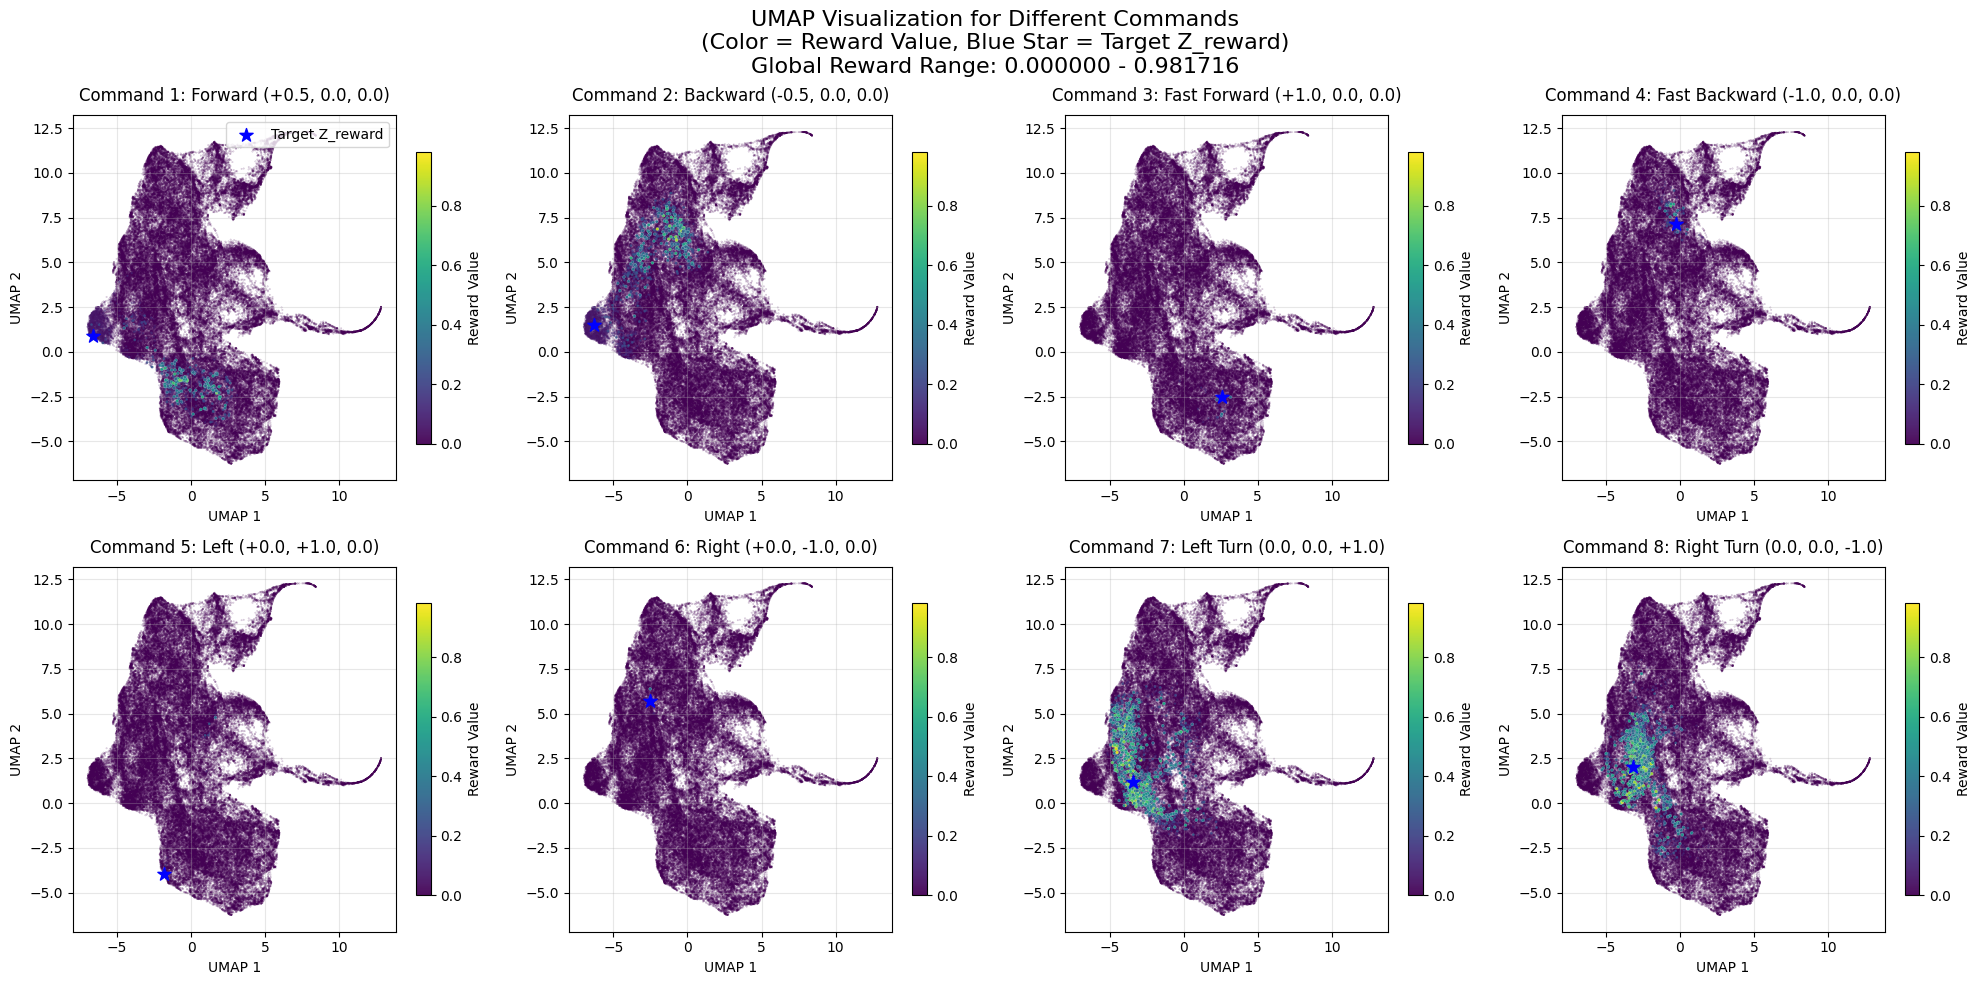

Global reward range: 0.000000 - 0.981716


In [13]:
# 创建8个子图，每个对应一个command
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 计算全局的reward范围，用于统一颜色条
global_vmin = np.min(rewards_list)
global_vmax = np.max(rewards_list)

for i in range(8):
    ax = axes[i]
    
    # 获取当前command的rewards (50000, 1) -> (50000,)
    current_rewards = rewards_list[i].flatten()
    
    # 创建多级奖励分组，从低到高，确保高奖励点在最上层
    reward_thresholds = [0.0, 0.1, 0.2, 0.3]
    sizes = [0.1, 0.3, 1.0, 3.0]
    alphas = [0.3, 0.5, 0.7, 0.9]
    
    scatter = None  # 用于创建colorbar
    
    # 从低奖励到高奖励依次绘制，确保高奖励点在上层
    for j in range(len(reward_thresholds)-1):
        mask = (current_rewards >= reward_thresholds[j]) & (current_rewards < reward_thresholds[j+1])
        if np.any(mask):
            scatter_temp = ax.scatter(
                Zs_embedding[mask, 0], 
                Zs_embedding[mask, 1],
                c=current_rewards[mask],
                cmap='viridis',
                s=sizes[j],
                alpha=alphas[j],
                rasterized=True,
                zorder=j+1,
                vmin=global_vmin,  # 使用全局范围
                vmax=global_vmax   # 使用全局范围
            )
            if scatter is None or j == len(reward_thresholds)-2:  # 使用最后一个有效的scatter
                scatter = scatter_temp
    
    # 处理最高奖励级别
    high_mask = current_rewards >= reward_thresholds[-1]
    if np.any(high_mask):
        scatter_high = ax.scatter(
            Zs_embedding[high_mask, 0], 
            Zs_embedding[high_mask, 1],
            c=current_rewards[high_mask],
            cmap='viridis',
            s=5.0,  # 最大的点
            alpha=0.95,
            rasterized=True,
            zorder=10,  # 最高层次
            edgecolors='white',
            linewidths=0.1,
            vmin=global_vmin,  # 使用全局范围
            vmax=global_vmax   # 使用全局范围
        )
        scatter = scatter_high
    
    # 添加目标点（当前command对应的Z_reward）
    ax.scatter(
        targets_embedding[i, 0],
        targets_embedding[i, 1], 
        c='blue',
        s=100,
        marker='*',
        linewidth=1,
        label='Target Z_reward',
        zorder=15  # 确保目标点在最上层
    )
    
    # 设置标题和标签
    ax.set_title(f'Command {i+1}: {command_labels[i]}', fontsize=12, pad=10)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(True, alpha=0.3)
    
    # 添加颜色条，使用统一的范围
    if scatter is not None:
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Reward Value', fontsize=10)
    
    # 添加图例（只对第一个子图）
    if i == 0:
        ax.legend(loc='upper right', fontsize=10)

plt.suptitle(f'UMAP Visualization for Different Commands\n(Color = Reward Value, Blue Star = Target Z_reward)\nGlobal Reward Range: {global_vmin:.6f} - {global_vmax:.6f}', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print(f"Global reward range: {global_vmin:.6f} - {global_vmax:.6f}")